#Estudio del procesamiento de imagenes
Autores:

    Juan José Zapata Moreno (juazapatamo@unal.edu.co)

    Alejandro Anaya (aanayal@unal.edu.co)

    Esteban Celis Hincapié (ecelish@unal.edu.co)

Fecha: 29 de Octubre de 2025

Curso: Instrumentos Ópticos

In [ ]:
#@title importar librerias
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont


##Definición de los parametros del sistema y la simulación

In [ ]:
LONGITUD_ONDA = 633e-9      # Longitud de onda (λ = 633 nm)
DISTANCIA_FOCAL = 500e-3    # Distancia focal de L1 y L2 (f = 500 mm)
DIAMETRO_L1 = 100e-3        # Diámetro de la lente L1
DIAMETRO_M2 = 50e-3
ANCHO_M1 = 10.4e-3          # Ancho del espejo M1
ALTO_M1 = 5.8e-3            # Alto del espejo M1
CAM1_PIXELES_X = 4640       # Píxeles de la cámara 1
CAM1_PIXELES_Y = 3506
TAMANO_PIXEL_CAM1 = 3.8e-6  # Lado del píxel de la cámara 1 (3.8 μm)
CAM2_PIXELES_X = 1280       # Píxeles de la cámara 2
CAM2_PIXELES_Y = 1024
TAMANO_PIXEL_CAM2 = 5.2e-6  # Lado del píxel de la cámara 2 (5.2 μm)

DIST_OBJ_BS = 250e-3        #Distancia del objeto al Beam splitter
DIST_BS_ESPEJO = 100e-3     #Distancia del Beam Splitter a el espejo
DIST_ESPEJO_LENTE = 250e-3  #Distancia del espejo a la lente
#Se hizo pensando que la distancia entre el objeto y el beam splitter y el del espejo a la lente sea igual a la distancia focal como se visualiza en el montaje



# Parámetros de la simulación
N = 1024  # Número de puntos de la malla
TAMANO_PLANO_ENTRADA = 20e-3  # Tamaño físico del plano de entrada

##Funciones principales

In [ ]:
#@title Propagación Matriz ABCD
def propagar_abcd(
    campo_entrada: np.ndarray,
    dx_entrada: float,
    longitud_onda: float,
    A: float, B: float, C: float, D: float
) -> tuple:
    """
    Propaga un campo óptico plano-paralelo usando la matriz ABCD y la formulación FFT de la integral de Collins.

    Args:
        campo_entrada (np.ndarray): Matriz compleja NxN con el campo en el plano de entrada.
        dx_entrada (float): Tamaño del píxel en el plano de entrada (m).
        longitud_onda (float): Longitud de onda de la luz (m).
        A, B, C, D (float): Elementos de la matriz de transferencia ABCD del sistema óptico.

    Returns:
        campo_salida (np.ndarray): Campo propagado en el plano de salida.
        dx_salida (float): Tamaño del píxel en el plano de salida (m).

    Notas:
        - Para B=0 (sistema de imagen), no aplica propagación difractiva y la función retorna el campo original.
        - El tamaño de salida es igual al de entrada, pero la escala espacial cambia.
    """
    # Validaciones
    if not isinstance(campo_entrada, np.ndarray):
        raise TypeError("campo_entrada debe ser un array de NumPy.")
    if campo_entrada.shape[0] != campo_entrada.shape[1]:
        raise ValueError("El campo de entrada debe ser una matriz cuadrada.")
    if B == 0:
        print("Advertencia: B=0 (sistema de imagen). Retornando campo original sin propagación.")
        return campo_entrada, dx_entrada

    N = campo_entrada.shape[0]
    k = 2 * np.pi / longitud_onda

    # Coordenadas del plano de entrada
    x = (np.arange(N) - N // 2) * dx_entrada
    X, Y = np.meshgrid(x, x)

    # Fase cuadrática inicial (plano de entrada)
    fase_inicial = np.exp(1j * k / (2 * B) * A * (X**2 + Y**2))
    campo_modificado = campo_entrada * fase_inicial

    # Transformada de Fourier (propagación)
    campo_fft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(campo_modificado)))

    # Tamaño de píxel en el plano de salida
    dx_salida = longitud_onda * abs(B) / (N * dx_entrada)
    x_salida = (np.arange(N) - N // 2) * dx_salida
    Xs, Ys = np.meshgrid(x_salida, x_salida)

    # Fase cuadrática final (plano de salida)
    fase_final = np.exp(1j * k / (2 * B) * D * (Xs**2 + Ys**2))

    # Factor de escala (incluye normalización y términos de propagación)
    factor_escala = np.exp(1j * k * B) / (1j * longitud_onda * abs(B))

    # Salida final
    campo_salida = factor_escala * campo_fft * fase_final * (dx_entrada ** 2)

    return campo_salida, dx_salida


In [ ]:
#@title Filtro adaptativo
def crear_filtro_muesca_adaptivo(
    campo_fourier,
    n_muescas_max=10,              # máximo de picos a anular (se agregan sus conjugados)
    radio_muesca_pix=15,            # “ancho” efectivo de cada muesca
    orden_butter=5,                 # suavidad de la muesca (>=2 recomendado)
    radio_exclusion_dc_pix=10,      # no tocar la DC
    radio_min_pix=15,               # no filtrar MUY cerca del centro
    radio_max_pix=None,             # si None, sin límite superior
    percentil_det=90, # umbral de detección (log-intensidad)
    N = 1024
    ):
    """
    Genera un filtro notch-stop suave (Butterworth) para eliminar picos espurios
    en el plano de Fourier (campo de M1). Respeta simetría y limita por radio.
    """
    F = campo_fourier
    N = F.shape[0]
    assert F.shape[0] == F.shape[1], "Se asume cuadrado."

    # 1) Espectro log para realzar picos (y reducir rango dinámico)
    I = np.abs(F)**2
    L = np.log1p(I)  # log(1+I)

    # 2) Apodización previa (Hanning 2D) para bajar leakage
    win = np.hanning(N)
    W = np.outer(win, win)
    Lw = L * W

    # 3) Candidatos por percentil
    thr = np.percentile(Lw, percentil_det)
    cand = np.argwhere(Lw > thr)

    # 4) Geometría
    cy = cx = N // 2
    yy, xx = np.mgrid[0:N, 0:N]
    rr = np.sqrt((yy - cy)**2 + (xx - cx)**2)

    if radio_max_pix is None:
        radio_max_pix = N/2 - 4

    # 5) Filtrar candidatos por radio permitido y fuera de DC
    mask_rango = (rr > max(radio_min_pix, radio_exclusion_dc_pix)) & (rr < radio_max_pix)
    cand = [tuple(p) for p in cand if mask_rango[p[0], p[1]]]

    # 6) Ordenar por intensidad descendente (en Lw)
    cand.sort(key=lambda p: Lw[p[0], p[1]], reverse=True)

    # 7) Selección con supresión por vecindad (no muescas solapadas)
    elegidos = []
    tomado = np.zeros((N, N), dtype=bool)
    supresion = max(6, radio_muesca_pix)  # zona de seguridad

    for (y, x) in cand:
        if len(elegidos) >= n_muescas_max:
            break
        if tomado[y, x]:
            continue

        # punto y su conjugado
        yc = (2*cy - y) % N
        xc = (2*cx - x) % N

        elegidos.append((y, x))
        elegidos.append((yc, xc))

        # marcar vecindad como tomada
        y0, y1 = max(0, y - supresion), min(N, y + supresion + 1)
        x0, x1 = max(0, x - supresion), min(N, x + supresion + 1)
        tomado[y0:y1, x0:x1] = True
        y0c, y1c = max(0, yc - supresion), min(N, yc + supresion + 1)
        x0c, x1c = max(0, xc - supresion), min(N, xc + supresion + 1)
        tomado[y0c:y1c, x0c:x1c] = True

    # 8) Construir filtro notch-stop Butterworth suave
    H = np.ones((N, N), dtype=float)

    def butter_notch(u, v, u0, v0, D0, n):
        # Distancia a pico y a su conjugado
        Dk  = np.sqrt((u - u0)**2 + (v - v0)**2)
        Dkc = np.sqrt((u + u0)**2 + (v + v0)**2)
        # Band-stop notch (suave)
        return 1.0 / (1.0 + (D0**2 / (Dk * Dkc + 1e-12))**n)

    # Coordenadas centradas
    U = xx - cx
    V = yy - cy

    for (y, x) in elegidos:
        u0 = x - cx
        v0 = y - cy
        H *= butter_notch(U, V, u0, v0, radio_muesca_pix, orden_butter)

    # 9) Proteger DC con un “tapón” gentil (no =0)
    H[rr < radio_exclusion_dc_pix] = 1.0

    return H


In [ ]:


def cargar_imagen_objeto(ruta_archivo, tamano_pixeles):
    """Carga una imagen, la convierte a escala de grises y la redimensiona."""
    try:
        img = Image.open(ruta_archivo).convert('L')
        img = img.resize((tamano_pixeles, tamano_pixeles), Image.Resampling.LANCZOS)
        img_array = np.array(img)
        if np.max(img_array) > 0:
            img_array = img_array / 255.0
        return img_array
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo '{ruta_archivo}'. Se usará un objeto de texto por defecto.")
        return crear_objeto_texto("?", tamano_pixeles, tamano_fuente=int(tamano_pixeles * 0.6))

def crear_apertura_rectangular(ancho, alto, tamano_m, N_pixeles):
    """Crea una apertura rectangular."""
    coordenadas = np.linspace(-tamano_m / 2, tamano_m / 2, N_pixeles)
    X, Y = np.meshgrid(coordenadas, coordenadas)
    apertura = np.zeros((N_pixeles, N_pixeles))
    apertura[(np.abs(X) < ancho / 2) & (np.abs(Y) < alto / 2)] = 1
    return apertura

def crear_filtro_muesca(campo_fourier, umbral_porcentual=0.1, radio_muesca_pixeles=8, radio_exclusion_dc_pixeles=15):
    """
    Crea un filtro de muesca para eliminar picos de frecuencia de ruido.
    """
    N_pixeles = campo_fourier.shape[0]
    intensidad = np.abs(campo_fourier)**2


    centro_y, centro_x = N_pixeles // 2, N_pixeles // 2
    yy, xx = np.mgrid[:N_pixeles, :N_pixeles]
    circulo_dc = (xx - centro_x)**2 + (yy - centro_y)**2 < radio_exclusion_dc_pixeles**2

    intensidad_sin_dc = np.copy(intensidad)
    intensidad_sin_dc[circulo_dc] = 0

    # Encontrar picos de ruido por encima de un umbral
    umbral = np.max(intensidad_sin_dc) * umbral_porcentual
    puntos_ruido = np.argwhere(intensidad_sin_dc > umbral)

    filtro = np.ones((N_pixeles, N_pixeles))

    # Dibujar círculos opacos (muescas) en las ubicaciones de los picos de ruido
    for y_ruido, x_ruido in puntos_ruido:
        muesca = (xx - x_ruido)**2 + (yy - y_ruido)**2 < radio_muesca_pixeles**2
        filtro[muesca] = 0

    return filtro




In [ ]:
from re import M
# Configuración de coordenadas del plano de entrada
dx = TAMANO_PLANO_ENTRADA / N
coordenadas = np.linspace(-TAMANO_PLANO_ENTRADA / 2, TAMANO_PLANO_ENTRADA / 2, N)

# Cargar imagen objeto S(ξ, η)
NOMBRE_ARCHIVO_ENTRADA = '/content/Noise (7).png'
S = cargar_imagen_objeto(NOMBRE_ARCHIVO_ENTRADA, N)

# TRAYECTORIA 1: S(ξ, η) -> M1(x, y) -> O(u, v) en Cámara 1

print("Calculando Trayectoria 1 (Cámara 1)...")

# a) Propagación S(ξ, η) -> plano focal de L1 (donde está M1)
# Esta es una transformada de Fourier óptica
A1, B1, C1, D1 = 0, DISTANCIA_FOCAL, -1/DISTANCIA_FOCAL, 0
campo_en_M1, dx_M1 = propagar_abcd(S, dx, LONGITUD_ONDA, A1, B1, C1, D1)

# b) Aplicar modulación de amplitud t(x, y) en el espejo M1
# M1 es rectangular: 10.4 mm × 5.8 mm
tamano_plano_M1 = N * dx_M1
mascara_fisica_espejo = crear_apertura_rectangular(ANCHO_M1, ALTO_M1, tamano_plano_M1, N)

# Si deseas agregar filtros adaptativos adicionales, combínalos aquí
filtro_muesca = crear_filtro_muesca_adaptivo(campo_en_M1)
mascara_espejo = mascara_fisica_espejo * filtro_muesca  # Combinar modulaciones
mascara_espejo = mascara_espejo
campo_despues_M1 = campo_en_M1 * mascara_espejo

# c) Propagación M1(x, y) -> O(u, v) en Cam1
# El campo reflejado pasa de nuevo por L1 (otra transformada de Fourier)
A2, B2, C2, D2 = 0, DISTANCIA_FOCAL, -1/DISTANCIA_FOCAL, 0
O, dx_cam1 = propagar_abcd(campo_despues_M1, dx_M1, LONGITUD_ONDA, A2, B2, C2, D2)

# d) Calcular la intensidad en la cámara 1
intensidad_cam1 = np.abs(O)**2
if np.max(intensidad_cam1) > 0:
    intensidad_cam1 /= np.max(intensidad_cam1)

# ====================================================================
# TRAYECTORIA 2: S(ξ, η) -> M2 -> U(x', y') en Cámara 2
# ====================================================================

print("Calculando Trayectoria 2 (Cámara 2)...")

# Construcción de la matriz ABCD compuesta
# M2 es un espejo PLANO circular de 50 mm de diámetro

# Distancias del sistema
d_entrada = DIST_OBJ_BS + DIST_BS_ESPEJO  # Distancia desde objeto hasta M2

M_prop_entrada = np.array([[1, d_entrada], [0, 1]])

# Espejo plano: matriz identidad (C = 0)
M_espejo_plano = np.array([[1, 0], [0, 1]])

# Propagación desde M2 hasta L2
M_prop_intermedia = np.array([[1, DIST_ESPEJO_LENTE], [0, 1]])

# Lente L2
M_lente = np.array([[1, 0], [-1/DISTANCIA_FOCAL, 1]])

# Propagación desde L2 hasta Cam2
# La distancia depende de d_entrada y la ecuación de lentes
M_prop_salida = np.array([[1, DISTANCIA_FOCAL], [0, 1]])

# Matriz total: multiplicar de derecha a izquierda
M_total_S_U = M_prop_salida @ M_lente @ M_prop_intermedia @ M_espejo_plano @ M_prop_entrada


# Extraer elementos ABCD
A3, B3, C3, D3 = M_total_S_U[0,0], M_total_S_U[0,1], M_total_S_U[1,0], M_total_S_U[1,1]

# Propagación directa desde S hasta posición antes de aplicar apertura circular
campo_U, dx_cam2 = propagar_abcd(S, dx, LONGITUD_ONDA, A3, B3, C3, D3)

# Calcular intensidad en Cámara 2
intensidad_cam2 = np.abs(campo_U)**2
if np.max(intensidad_cam2) > 0:
    #intensidad_cam2 /= np.max(intensidad_cam2)
    intensidad_cam2 = np.log(1e-9 + intensidad_cam2)


print("Cálculos completados.")

Calculando Trayectoria 1 (Cámara 1)...
Calculando Trayectoria 2 (Cámara 2)...
Cálculos completados.


##  Simulación

En esta sección se presentan las simulaciones correspondientes a dos trayectorias ópticas distintas, usando notación explícita de los planos y las matrices ABCD involucradas.

---

###  Trayectoria 1: $S(\xi, \eta) \rightarrow M_1(x, y) \rightarrow O(u, v)$ $(\text{Cam}_1(x', y'))$

1. **Propagación del plano objeto $S(\xi, \eta)$ al espejo $M_1(x, y)$:**  
   El campo se propaga mediante la matriz ABCD:

   $$
   \begin{bmatrix}
   0 & f \\\\
   -\dfrac{1}{f} & 0
   \end{bmatrix}
   $$

2. **Aplicación de la transmitancia en el plano $M_1$:**  
   Sobre el campo en $M_1(x, y)$ se aplica la transmitancia desconocida $t(x, y)$, que representa tanto la apertura física como posibles filtros adaptativos.

3. **Propagación desde $M_1(x, y)$ a $O(u, v)$:**  
   Se utiliza nuevamente la misma matriz ABCD:

   $$
   \begin{bmatrix}
   0 & f \\\\
   -\dfrac{1}{f} & 0
   \end{bmatrix}
   $$

4. **Cálculo de la intensidad en $O(u, v)$:**  
   La intensidad se obtiene como el **módulo cuadrado del campo complejo**, normalizado para facilitar su comparación:

   $$
   I(u, v) = \left| U(u, v) \right|^2
   $$

---

## Trayectoria 2: $S(\xi,\eta) \rightarrow U(x',y')$ en Cam2

###  Propagación con reflexión en M2

El campo $S(\xi,\eta)$ es reflejado por el divisor de haz (**BS**) hacia el espejo circular plano **M2** (diámetro 50 mm).  
Este espejo actúa como un **reflector plano ideal** con apertura circular que limita el haz.

---

###  Sistema de matrices ABCD compuesto

La propagación completa incluye:

- Propagación libre inicial  
- Reflexión en el espejo plano  
- Propagación intermedia  
- Paso por la lente L2  
- Propagación final

La matriz total es:

$$
M_{\text{total}} = M_{\text{propagación final}} \cdot M_{\text{lente}} \cdot M_{\text{propagación intermedia}} \cdot M_{\text{espejo plano}} \cdot M_{\text{propagación inicial}}
$$

$$
M_{\text{total}} = \begin{bmatrix}
0 &  f  \\
-\dfrac{1}{f} & -\dfrac{d_2}{f}
\end{bmatrix}
$$

### Cálculo de intensidad

La intensidad en el plano $U(x',y') \equiv \text{Cam2}$ se calcula como:

$$
I(x',y') = |U(x',y')|^2
$$

El campo se **normaliza** después de la propagación para mantener coherencia con la energía total del haz.


#Visualización de resultados

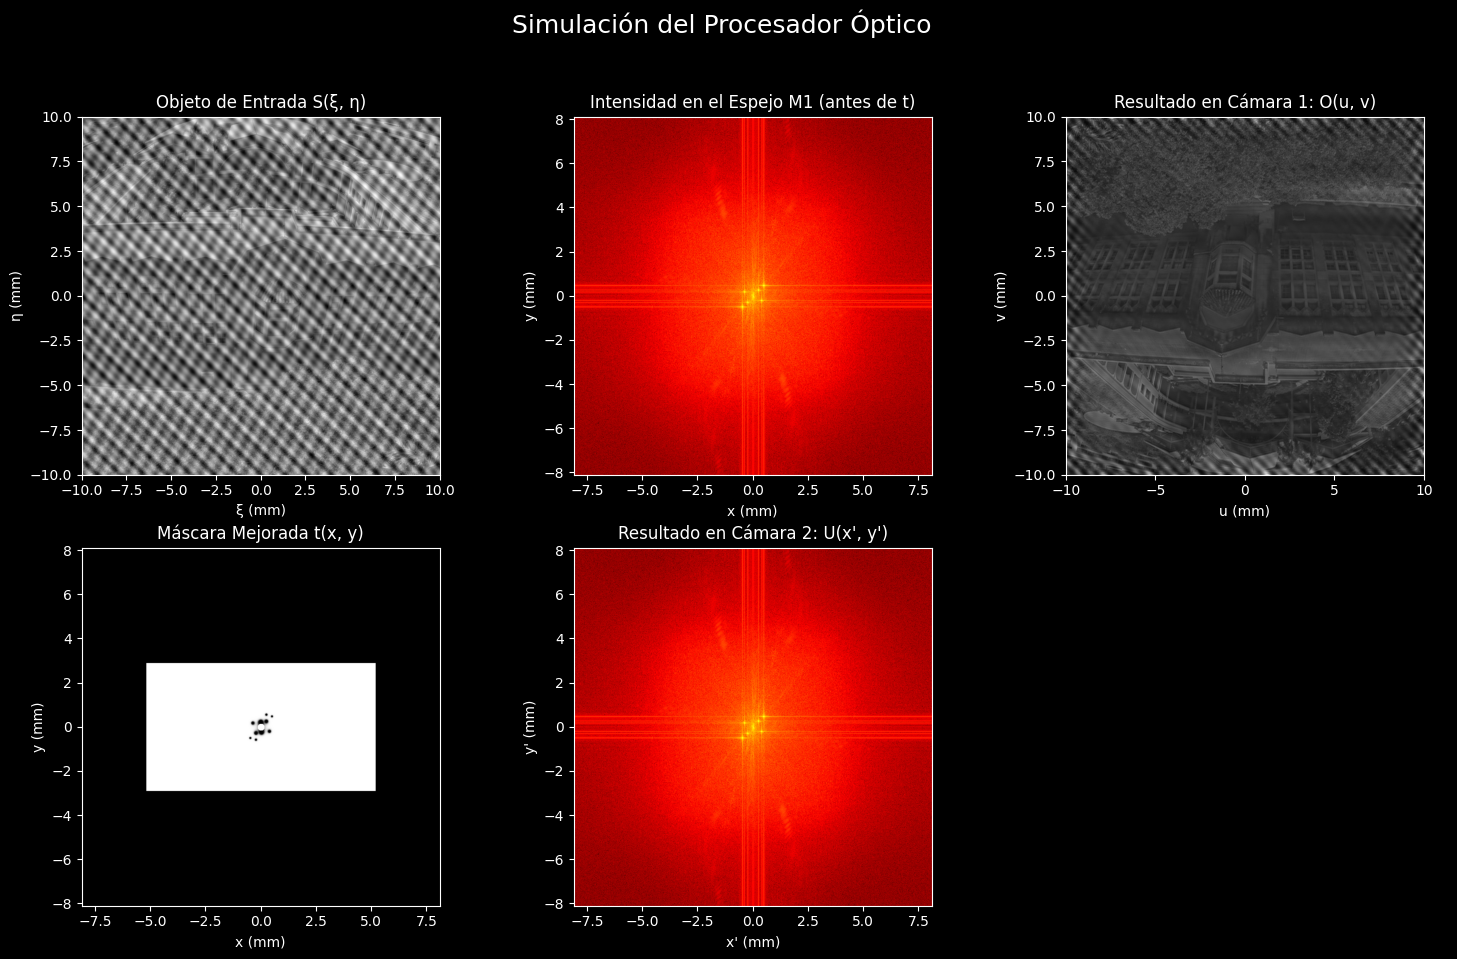

In [ ]:
plt.style.use('dark_background')
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Simulación del Procesador Óptico', fontsize=18)

rango_entrada_mm = TAMANO_PLANO_ENTRADA / 2e-3
axes[0, 0].imshow(S, cmap='gray', extent=[-rango_entrada_mm, rango_entrada_mm, -rango_entrada_mm, rango_entrada_mm])
axes[0, 0].set_title('Objeto de Entrada S(ξ, η)')
axes[0, 0].set_xlabel('ξ (mm)')
axes[0, 0].set_ylabel('η (mm)')

rango_m1_mm = tamano_plano_M1 / 2e-3
axes[1, 0].imshow(mascara_espejo, cmap='gray', extent=[-rango_m1_mm, rango_m1_mm, -rango_m1_mm, rango_m1_mm])
axes[1, 0].set_title('Máscara Mejorada t(x, y)')
axes[1, 0].set_xlabel('x (mm)')
axes[1, 0].set_ylabel('y (mm)')

intensidad_espejo = np.abs(campo_en_M1)**2
intensidad_espejo_log = np.log(1e-9 + intensidad_espejo)
axes[0, 1].imshow(intensidad_espejo_log, cmap='hot', extent=[-rango_m1_mm, rango_m1_mm, -rango_m1_mm, rango_m1_mm])
axes[0, 1].set_title('Intensidad en el Espejo M1 (antes de t)')
axes[0, 1].set_xlabel('x (mm)')
axes[0, 1].set_ylabel('y (mm)')

rango_cam2_mm = (N * dx_cam2 * 1e3) / 2
axes[1, 1].imshow(intensidad_cam2, cmap='hot', extent=[-rango_cam2_mm, rango_cam2_mm, -rango_cam2_mm, rango_cam2_mm])
axes[1, 1].set_title('Resultado en Cámara 2: U(x\', y\')')
axes[1, 1].set_xlabel("x' (mm)")
axes[1, 1].set_ylabel("y' (mm)")

rango_cam1_mm = (N * dx_cam1 * 1e3) / 2
axes[0, 2].imshow(intensidad_cam1, cmap='gray', extent=[-rango_cam1_mm, rango_cam1_mm, -rango_cam1_mm, rango_cam1_mm])
axes[0, 2].set_title('Resultado en Cámara 1: O(u, v)')
axes[0, 2].set_xlabel('u (mm)')
axes[0, 2].set_ylabel('v (mm)')

axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



In [ ]:
from re import M
# Configuración de coordenadas del plano de entrada
dx = TAMANO_PLANO_ENTRADA / N
coordenadas = np.linspace(-TAMANO_PLANO_ENTRADA / 2, TAMANO_PLANO_ENTRADA / 2, N)

# Cargar imagen objeto S(ξ, η)
NOMBRE_ARCHIVO_ENTRADA = '/content/Noise (15).png'
S = cargar_imagen_objeto(NOMBRE_ARCHIVO_ENTRADA, N)

# TRAYECTORIA 1: S(ξ, η) -> M1(x, y) -> O(u, v) en Cámara 1

print("Calculando Trayectoria 1 (Cámara 1)...")

# a) Propagación S(ξ, η) -> plano focal de L1 (donde está M1)
# Esta es una transformada de Fourier óptica
A1, B1, C1, D1 = 0, DISTANCIA_FOCAL, -1/DISTANCIA_FOCAL, 0
campo_en_M1, dx_M1 = propagar_abcd(S, dx, LONGITUD_ONDA, A1, B1, C1, D1)

# b) Aplicar modulación de amplitud t(x, y) en el espejo M1
# M1 es rectangular: 10.4 mm × 5.8 mm
tamano_plano_M1 = N * dx_M1
mascara_fisica_espejo = crear_apertura_rectangular(ANCHO_M1, ALTO_M1, tamano_plano_M1, N)

# Si deseas agregar filtros adaptativos adicionales, combínalos aquí
filtro_muesca = crear_filtro_muesca_adaptivo(campo_en_M1)
mascara_espejo = mascara_fisica_espejo * filtro_muesca  # Combinar modulaciones
mascara_espejo = mascara_espejo
campo_despues_M1 = campo_en_M1 * mascara_espejo

# c) Propagación M1(x, y) -> O(u, v) en Cam1
# El campo reflejado pasa de nuevo por L1 (otra transformada de Fourier)
A2, B2, C2, D2 = 0, DISTANCIA_FOCAL, -1/DISTANCIA_FOCAL, 0
O, dx_cam1 = propagar_abcd(campo_despues_M1, dx_M1, LONGITUD_ONDA, A2, B2, C2, D2)

# d) Calcular la intensidad en la cámara 1
intensidad_cam1 = np.abs(O)**2
if np.max(intensidad_cam1) > 0:
    intensidad_cam1 /= np.max(intensidad_cam1)

# ====================================================================
# TRAYECTORIA 2: S(ξ, η) -> M2 -> U(x', y') en Cámara 2
# ====================================================================

print("Calculando Trayectoria 2 (Cámara 2)...")

# Construcción de la matriz ABCD compuesta
# M2 es un espejo PLANO circular de 50 mm de diámetro

# Distancias del sistema
d_entrada = DIST_OBJ_BS + DIST_BS_ESPEJO  # Distancia desde objeto hasta M2

M_prop_entrada = np.array([[1, d_entrada], [0, 1]])

# Espejo plano: matriz identidad (C = 0)
M_espejo_plano = np.array([[1, 0], [0, 1]])

# Propagación desde M2 hasta L2
M_prop_intermedia = np.array([[1, DIST_ESPEJO_LENTE], [0, 1]])

# Lente L2
M_lente = np.array([[1, 0], [-1/DISTANCIA_FOCAL, 1]])

# Propagación desde L2 hasta Cam2
# La distancia depende de d_entrada y la ecuación de lentes
M_prop_salida = np.array([[1, DISTANCIA_FOCAL], [0, 1]])

# Matriz total: multiplicar de derecha a izquierda
M_total_S_U = M_prop_salida @ M_lente @ M_prop_intermedia @ M_espejo_plano @ M_prop_entrada


# Extraer elementos ABCD
A3, B3, C3, D3 = M_total_S_U[0,0], M_total_S_U[0,1], M_total_S_U[1,0], M_total_S_U[1,1]

# Propagación directa desde S hasta posición antes de aplicar apertura circular
campo_U, dx_cam2 = propagar_abcd(S, dx, LONGITUD_ONDA, A3, B3, C3, D3)

# Calcular intensidad en Cámara 2
intensidad_cam2 = np.abs(campo_U)**2
if np.max(intensidad_cam2) > 0:
    #intensidad_cam2 /= np.max(intensidad_cam2)
    intensidad_cam2 = np.log(1e-9 + intensidad_cam2)


print("Cálculos completados.")

Calculando Trayectoria 1 (Cámara 1)...
Calculando Trayectoria 2 (Cámara 2)...
Cálculos completados.


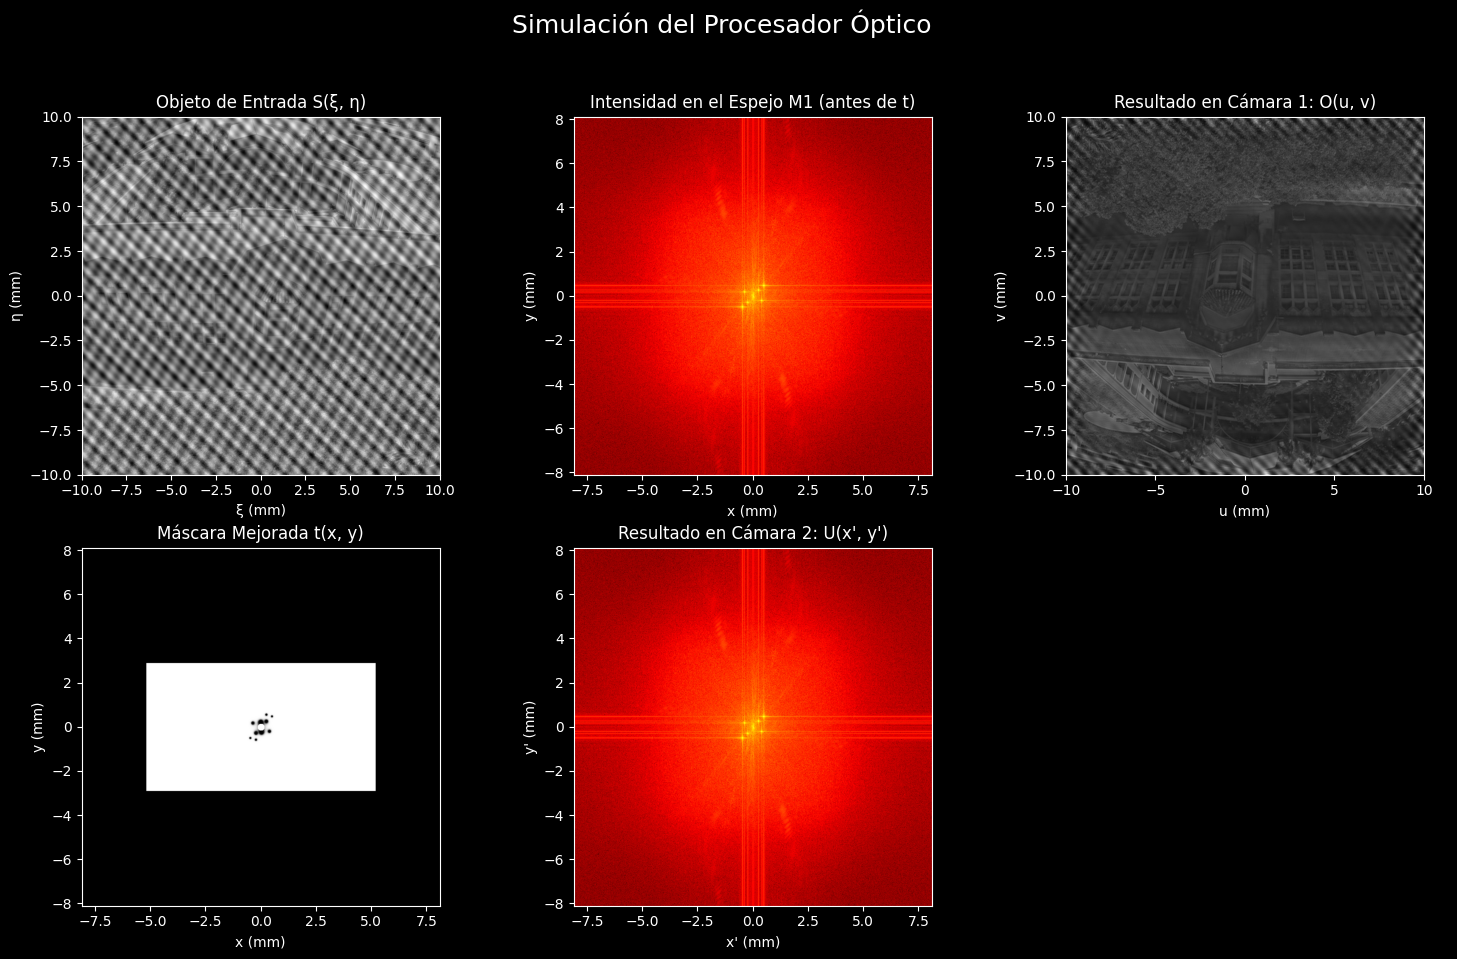

In [ ]:
plt.style.use('dark_background')
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Simulación del Procesador Óptico', fontsize=18)

rango_entrada_mm = TAMANO_PLANO_ENTRADA / 2e-3
axes[0, 0].imshow(S, cmap='gray', extent=[-rango_entrada_mm, rango_entrada_mm, -rango_entrada_mm, rango_entrada_mm])
axes[0, 0].set_title('Objeto de Entrada S(ξ, η)')
axes[0, 0].set_xlabel('ξ (mm)')
axes[0, 0].set_ylabel('η (mm)')

rango_m1_mm = tamano_plano_M1 / 2e-3
axes[1, 0].imshow(mascara_espejo, cmap='gray', extent=[-rango_m1_mm, rango_m1_mm, -rango_m1_mm, rango_m1_mm])
axes[1, 0].set_title('Máscara Mejorada t(x, y)')
axes[1, 0].set_xlabel('x (mm)')
axes[1, 0].set_ylabel('y (mm)')

intensidad_espejo = np.abs(campo_en_M1)**2
intensidad_espejo_log = np.log(1e-9 + intensidad_espejo)
axes[0, 1].imshow(intensidad_espejo_log, cmap='hot', extent=[-rango_m1_mm, rango_m1_mm, -rango_m1_mm, rango_m1_mm])
axes[0, 1].set_title('Intensidad en el Espejo M1 (antes de t)')
axes[0, 1].set_xlabel('x (mm)')
axes[0, 1].set_ylabel('y (mm)')

rango_cam2_mm = (N * dx_cam2 * 1e3) / 2
axes[1, 1].imshow(intensidad_cam2, cmap='hot', extent=[-rango_cam2_mm, rango_cam2_mm, -rango_cam2_mm, rango_cam2_mm])
axes[1, 1].set_title('Resultado en Cámara 2: U(x\', y\')')
axes[1, 1].set_xlabel("x' (mm)")
axes[1, 1].set_ylabel("y' (mm)")

rango_ca21_mm = (N * dx_cam1 * 1e3) / 2
axes[0, 2].imshow(intensidad_cam1, cmap='gray', extent=[-rango_cam1_mm, rango_cam1_mm, -rango_cam1_mm, rango_cam1_mm])
axes[0, 2].set_title('Resultado en Cámara 1: O(u, v)')
axes[0, 2].set_xlabel('u (mm)')
axes[0, 2].set_ylabel('v (mm)')

axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

